# rule based feature 추출

In [52]:
import numpy as np
import pandas as pd
from pathlib import Path
# import Project_LG_Welding_AD.src.extract_rule_based_features as extract_rule_based_features
from Project_LG_Welding_AD.src.extract_rule_based_features import ExtractFeatures, detect_bead
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from matplotlib import pyplot as plt
from collections import Counter
import os
import torch
from sklearn.preprocessing import MinMaxScaler, StandardScaler


%matplotlib inline

wd = Path.cwd()
data_path = wd.parent / 'data'

## Anode

In [53]:
wd

PosixPath('/workspace/LG_sangiwon')

In [54]:
data_path

PosixPath('/workspace/data')

In [55]:
data_path = '/workspace/LG_sangiwon/data/'

In [56]:
Anode_Normal = sorted([x for x in Path(os.path.join(data_path, "230507/Anode/Normal")).glob("*.csv")])
Anode_Normal = sorted(Anode_Normal)

Anode_Abnormal = sorted([x for x in Path(os.path.join(data_path, "230507/Anode/Abnormal")).glob("*.csv")])
Anode_Abnormal = sorted(Anode_Abnormal)
len(Anode_Normal), len(Anode_Abnormal)

(35, 18)

In [57]:
# data = pd.read_csv(os.path.join(data_path, "230507/Anode/Normal/20230412_110032_0__03_Total.csv"))
# len(data)

# data2 = pd.read_csv(os.path.join(data_path, "230507/Anode/Normal/31.csv"))
# len(data2)

In [58]:
def check_graph(xs, att=None, piece=1, threshold=None):
    """
    anomaly score and anomaly label visualization

    Parameters
    ----------
    xs : np.ndarray
        anomaly scores
    att : np.ndarray
        anomaly labels
    piece : int
        number of figures to separate
    threshold : float(default=None)
        anomaly threshold

    Return
    ------
    fig : plt.figure
    """
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(12, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = np.arange(L, R)
        if piece == 1:
            ax = axs
        else:
            ax = axs[i]
        ax.plot(xticks, xs[L:R], color='#0C090A')
        ymin, ymax = ax.get_ylim()
        ymin = 0
        ax.set_ylim(ymin, ymax)
        if len(xs[L:R]) > 0 and att is not None:
            ax.vlines(xticks[np.where(att[L:R] == 1)], ymin=ymin, ymax=ymax, color='#FED8B1',
                          alpha=0.6, label='true anomaly')
        ax.plot(xticks, xs[L:R], color='#0C090A', label='anomaly score')
        if threshold is not None:
            ax.axhline(y=threshold, color='r', linestyle='--', alpha=0.8, label=f'threshold:{threshold:.4f}')
        ax.legend()

    return fig

### Dataset별 bead detection 후 time series concat

In [59]:
def slice_bead_data(path, set_bead_100=False):
    "path: data 저장 경로 (str)"
    extractor = ExtractFeatures(path)
    data = extractor.data
    if 'Abnormal' in path:
        data['label'] = 1
        data['dataset_idx'] = path[-12:-10]
    else:
        data['label'] = 0
        data['dataset_idx'] = str(path).split('/')[-1].split('.')[0]
    bead_array = detect_bead(data['LO'])
    data['bead_num'] = '0'
    
    if not set_bead_100:
        total_data = data.iloc[bead_array[0][0]:bead_array[0][1]+1]
    else:
        total_data = data.iloc[bead_array[0][0]:bead_array[0][0]+100]
    
    if 'Abnormal' in path:
        total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
    
    else:
        total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)

    if not set_bead_100:
        for i in range(1, len(bead_array)):
            bead_data = data.iloc[bead_array[i][0]:bead_array[i][1]]
            bead_data['bead_num'] = str(i)
            if 'Abnormal' in path:
                bead_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(i)
            
            else:
                bead_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(i)
                
            total_data = pd.concat([total_data, bead_data])

    else:
        for i in range(1, len(bead_array)):
            bead_data = data.iloc[bead_array[i][0]:bead_array[i][0]+100]
            bead_data['bead_num'] = str(i)
            if 'Abnormal' in path:
                bead_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(i)
            
            else:
                bead_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(i)
                
            total_data = pd.concat([total_data, bead_data])
                
    return total_data

def calc_point2point(predict, actual):
    """
    calculate f1 score by predict and actual.
    Args:
        predict (np.ndarray): the predict label
        actual (np.ndarray): np.ndarray
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)
    precision = TP / (TP + FP + 0.00001)
    recall = TP / (TP + FN + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    return f1, precision, recall, TP, TN, FP, FN


def adjust_predicts(score, label,
                    threshold=None,
                    pred=None,
                    calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    for i in range(len(score)):
        if actual[i] and predict[i] and not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                for j in range(i, 0, -1):
                    if not actual[j]:
                        break
                    else:
                        if not predict[j]:
                            predict[j] = True
                            latency += 1
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def PA_percentile(score, label,
                  threshold=None,
                  pred=None,
                  K=100,
                  calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    anomalies = []

    for i in range(len(actual)):
        if actual[i]:
            if not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                anomalies.append([i, i])
            else:
                anomalies[-1][-1] = i
        else:
            anomaly_state = False

    for i, [start, end] in enumerate(anomalies):
        collect = Counter(predict[start:end + 1])[1]
        anomaly_count += collect
        collect_ratio = collect / (end - start + 1)

        if collect_ratio * 100 >= K and collect > 0:
            predict[start:end + 1] = True
            latency += (end - start + 1) - collect

    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def calc_seq(score, label, threshold, K=0, calc_latency=False):
    """
    Calculate f1 score for a score sequence
    """
    if calc_latency:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        #predict, latency = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict, latency = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        t.append(latency)
        return t
    else:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        # predict = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        return t


def bf_search(score, label, start, end=None, step_num=1, display_freq=1, K=0, verbose=True) -> object:
    """
    Find the best-f1 score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-f1
    """
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = (-1., -1., -1.)
    m_t = 0.0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        target = calc_seq(score, label, threshold, K=K, calc_latency=True)
        if target[0] > m[0]:
            m_t = threshold
            m = target
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)
    return m, m_t

## Train Test split
### Train -> 35개 정상 dataset 중 80%인 28개
### Test -> 18개 비정상 dataset + 정상 7개 dataset = 25개 dataset

In [60]:
len(Anode_Normal)

35

In [10]:
data_folder_list = Anode_Normal + Anode_Abnormal
num_train_dataset = 28
Anode_Train = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','bead_num'])
Anode_Test = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','bead_num'])
for i in range(num_train_dataset):
    bead_i = slice_bead_data(str(data_folder_list[i]),set_bead_100=True)
    Anode_Train = pd.concat([Anode_Train, bead_i])

for i in range(num_train_dataset, len(data_folder_list)):
    bead_i = slice_bead_data(str(data_folder_list[i]),set_bead_100=True)
    Anode_Test = pd.concat([Anode_Test, bead_i])


Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Detected bead num: 54


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [61]:
import pickle

In [15]:
# with open('./data/Anode_Train.pkl', 'wb') as f:
#     pickle.dump(Anode_Train, f)

In [16]:
# with open('./data/Anode_Test.pkl', 'wb') as f:
#     pickle.dump(Anode_Test, f)

In [62]:
with open('./data/Anode_Train.pkl', 'rb') as f:
    Anode_Train = pickle.load(f)

In [63]:
with open('./data/Anode_Test.pkl', 'rb') as f:
    Anode_Test = pickle.load(f)

In [64]:
Anode_Train

,LO,BR,NIR,VIS,label,dataset_idx,bead_num,identifier
40138,0.028640,0.016105,0.012584,-0.000435,0,1,0,Normal_1_0
40139,1.351228,0.023538,0.024242,-0.000435,0,1,0,Normal_1_0
40140,2.425002,0.316958,0.030394,-0.000111,0,1,0,Normal_1_0
40141,2.932646,0.781971,0.031365,0.000536,0,1,0,Normal_1_0
40142,3.150438,1.302565,0.032337,0.002478,0,1,0,Normal_1_0
...,...,...,...,...,...,...,...,...
70778,3.322345,1.283500,0.187766,0.104103,0,34,53,Normal_34_53
70779,3.308450,1.235027,0.205252,0.110576,0,34,53,Normal_34_53
70780,3.292294,1.204005,0.208814,0.122227,0,34,53,Normal_34_53
70781,3.233160,1.202066,0.183557,0.129671,0,34,53,Normal_34_53


In [65]:
Anode_Train.groupby(['identifier']).count()

,LO,BR,NIR,VIS,label,dataset_idx,bead_num
identifier,,,,,,,
Normal_10_0,100,100,100,100,100,100,100
Normal_10_1,100,100,100,100,100,100,100
Normal_10_10,100,100,100,100,100,100,100
Normal_10_11,100,100,100,100,100,100,100
Normal_10_12,100,100,100,100,100,100,100
...,...,...,...,...,...,...,...
Normal_3_53,100,100,100,100,100,100,100
Normal_3_6,100,100,100,100,100,100,100
Normal_3_7,100,100,100,100,100,100,100


In [66]:
Anode_Train.groupby(['identifier']).count()['bead_num'].unique()

array([100])

In [67]:
Anode_Test.groupby(['identifier']).count()['bead_num'].unique()

array([100])

In [68]:
Anode_Train['dataset_idx'].unique()

array(['1', '10', '11', '12', '14', '15', '16', '17', '18', '19', '2',
       '20', '20230412_110032_0__03_Total', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '3', '30', '31', '32', '33', '34'],
      dtype=object)

In [69]:
Anode_Train['identifier']

40138      Normal_1_0
40139      Normal_1_0
40140      Normal_1_0
40141      Normal_1_0
40142      Normal_1_0
             ...     
70778    Normal_34_53
70779    Normal_34_53
70780    Normal_34_53
70781    Normal_34_53
70782    Normal_34_53
Name: identifier, Length: 151200, dtype: object

In [70]:
Anode_Train_y = Anode_Train['label'].astype(float)
Anode_Train_X = Anode_Train.drop(['label', 'dataset_idx', 'bead_num', 'identifier'], axis=1)
Anode_Test_y = Anode_Test['label'].astype(float)
Anode_Test_X = Anode_Test.drop(['label', 'dataset_idx', 'bead_num', 'identifier'], axis=1)

In [71]:
Anode_Train_X

,LO,BR,NIR,VIS
40138,0.028640,0.016105,0.012584,-0.000435
40139,1.351228,0.023538,0.024242,-0.000435
40140,2.425002,0.316958,0.030394,-0.000111
40141,2.932646,0.781971,0.031365,0.000536
40142,3.150438,1.302565,0.032337,0.002478
...,...,...,...,...
70778,3.322345,1.283500,0.187766,0.104103
70779,3.308450,1.235027,0.205252,0.110576
70780,3.292294,1.204005,0.208814,0.122227
70781,3.233160,1.202066,0.183557,0.129671


In [72]:
import sys
sys.path.append("./TSAD")

In [73]:
from tsad.data import BuildDataset
from tsad.models import BeatGAN_MOCAP
from tsad.models import UsadModel
from tsad.metrics import bf_search, get_best_f1

In [74]:
window_size = 100
slide_size = 100 # USAD의 경우 value와 window가 대응이 되어야 하기 때문에 slide size = 1
model_type = 'reconstruction'
# valid_split_rate = 0.8
device = torch.device('cuda:{}'.format(0))

loader_params = {
    'batch_size': 32,
    'shuffle': False,
    'num_workers': 8,
    'pin_memory': False
}

In [75]:
scaler = StandardScaler()
Anode_Train_X_scaled = pd.DataFrame(scaler.fit_transform(Anode_Train_X))
Anode_Test_X_scaled = pd.DataFrame(scaler.transform(Anode_Test_X))

In [76]:
Anode_train_dataset = BuildDataset(Anode_Train_X_scaled, Anode_Train_X_scaled.index.to_numpy(), window_size, slide_size,
                            attacks=None, model_type=model_type)

Anode_test_dataset = BuildDataset(Anode_Test_X_scaled, Anode_Test_X_scaled.index.to_numpy(), window_size, slide_size,
                            attacks=np.array(Anode_Test_y), model_type=model_type)

# of valid windows: 1512
# of valid windows: 1350


In [77]:
# w_size, z_size 정의

hidden_size = 100
# w_size = window_size*len(Anode_Train_X_scaled[0]) # window size * feature 수
w_size = window_size*4 # window size * feature 수
z_size = window_size * hidden_size

In [78]:
import torch.utils.data as data_utils

Anode_train_dataloader = torch.utils.data.DataLoader(Anode_train_dataset,
                                                batch_size=loader_params['batch_size'],
                                                shuffle=loader_params['shuffle'],
                                                num_workers=loader_params['num_workers'],
                                                pin_memory=loader_params['pin_memory'],
                                                drop_last=False)


Anode_test_dataloader = torch.utils.data.DataLoader(Anode_test_dataset,
                                                batch_size=loader_params['batch_size'],
                                                shuffle=loader_params['shuffle'],
                                                num_workers=loader_params['num_workers'],
                                                pin_memory=loader_params['pin_memory'],
                                                drop_last=False)

In [79]:
model = UsadModel(w_size, z_size)
model = UsadModel.to_device(model,device)

In [80]:
N_EPOCHS = 10
history = UsadModel.training(N_EPOCHS,model,Anode_train_dataloader, w_size)

100%|██████████| 10/10 [00:08<00:00,  1.11it/s]


In [81]:
results=UsadModel.testing(model,Anode_test_dataloader,w_size)

In [82]:
tst_label = np.array(Anode_Test_y)

In [83]:
windows_labels=[]
for i in range(0, len(tst_label), window_size):
    windows_labels.append(list(np.int_(tst_label[i:i+window_size])))

In [84]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]

In [85]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])


In [86]:
len(y_pred), len(y_test)

(1350, 1350)

In [87]:
y_test = np.array(y_test)

## get_best_f1으로 계산한 경우

In [112]:
(f1, recall, precision, _, _, _, _), threshold = get_best_f1(y_pred, y_test)

***computing best f1***
***  best_f1  ***:  0.9918317249314914
*** threshold ***:  0.55671614


In [113]:
print(f'f1: {f1}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'roc_auc: {roc_auc}')
print(f'threshold: {threshold}')

f1: 0.9918317249314914
precision: 0.9999999897119343
recall: 0.9838056580586472
roc_auc: 0.8007245193459185
threshold: 0.5567161440849304


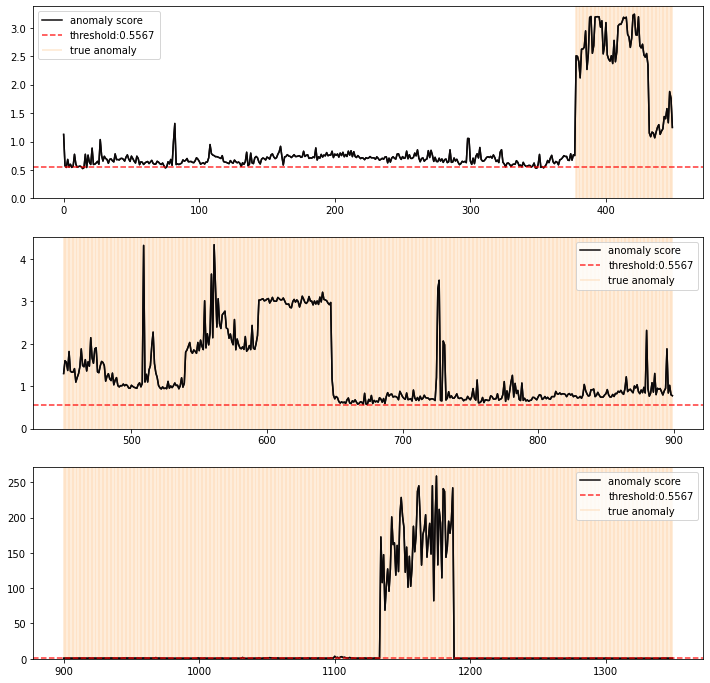

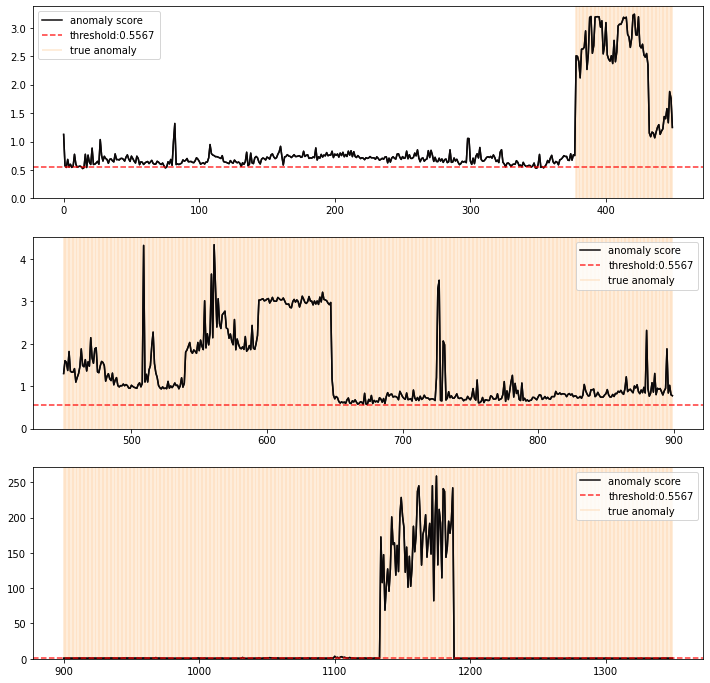

In [135]:
check_graph(y_pred, att=y_test, piece=3, threshold=0.5567161440849304)

## bf_search로 계산한 경우 step_num=10000

In [91]:
dist = y_pred
attack = y_test
history = dict()

scores = dist.copy()

In [104]:
[f1, precision, recall, _, _, _, _, roc_auc, _, _], threshold = bf_search(scores, attack,
                                                                            start=np.percentile(scores, 0),
                                                                            end=np.percentile(scores, 99),
                                                                            step_num=10000,
                                                                            K=100,
                                                                            verbose=False)

In [105]:
print(f'f1: {f1}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'roc_auc: {roc_auc}')
print(f'threshold: {threshold}')

f1: 0.8450777919174587
precision: 0.7322775208727186
recall: 0.9989711831381566
roc_auc: 0.8007245193459185
threshold: 0.5636254923801423


## bf_search로 계산한 경우 step_num=1000

In [114]:
[f1, precision, recall, _, _, _, _, roc_auc, _, _], threshold = bf_search(scores, attack,
                                                                            start=np.percentile(scores, 0),
                                                                            end=np.percentile(scores, 99),
                                                                            step_num=1000,
                                                                            K=100,
                                                                            verbose=False)

In [115]:
print(f'f1: {f1}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'roc_auc: {roc_auc}')
print(f'threshold: {threshold}')

f1: 0.7873001477116423
precision: 0.8580096983251251
recall: 0.7273662476608411
roc_auc: 0.8007245193459185
threshold: 0.7219560828113556


## 일단 여기까지

In [104]:
dist = y_pred
attack = y_test
history = dict()

scores = dist.copy()
    
K = [0, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
f1_values = []

print(f'Threshold start: {np.percentile(scores, 90):.4f} end: {np.percentile(scores, 99):.4f}')

for k in K:
    scores = dist.copy()
    [f1, precision, recall, _, _, _, _, roc_auc, _, _], threshold = bf_search(scores, attack,
                                                                                start=np.percentile(scores, 90),
                                                                                end=np.percentile(scores, 99),
                                                                                step_num=1000,
                                                                                K=k,
                                                                                verbose=False)
    f1_values.append(f1)
    print(f"K: {k} precision: {precision:.4f} recall: {recall:.4f} f1: {f1:.4f} AUROC: {roc_auc:.4f}")
    print(threshold)
    history.setdefault(f'precision_{k}', []).append(precision)
    history.setdefault(f'recall_{k}', []).append(recall)
    history.setdefault(f'f1_{k}', []).append(f1)
    history.setdefault(f'roc_auc', []).append(roc_auc)
    
auc = 0
for i in range(len(K) - 1):
    auc += 0.5 * (f1_values[i] + f1_values[i + 1]) * (int(K[i + 1]) - int(K[i]))
auc /= 100
print(f'PA%K AUC: {auc}')

Threshold start: 2.8908 end: 199.8088
K: 0 precision: 1.0000 recall: 1.0000 f1: 1.0000 AUROC: 0.8031
199.8088391113281
K: 1 precision: 1.0000 recall: 1.0000 f1: 1.0000 AUROC: 0.8031
199.8088391113281
K: 2 precision: 1.0000 recall: 0.0144 f1: 0.0284 AUROC: 0.8031
199.8088391113281
K: 3 precision: 1.0000 recall: 0.0144 f1: 0.0284 AUROC: 0.8031
199.8088391113281
K: 4 precision: 1.0000 recall: 0.0144 f1: 0.0284 AUROC: 0.8031
199.8088391113281
K: 5 precision: 1.0000 recall: 0.0144 f1: 0.0284 AUROC: 0.8031
199.8088391113281
K: 10 precision: 1.0000 recall: 0.0144 f1: 0.0284 AUROC: 0.8031
199.8088391113281
K: 20 precision: 1.0000 recall: 0.0144 f1: 0.0284 AUROC: 0.8031
199.8088391113281
K: 30 precision: 1.0000 recall: 0.0144 f1: 0.0284 AUROC: 0.8031
199.8088391113281
K: 40 precision: 1.0000 recall: 0.0144 f1: 0.0284 AUROC: 0.8031
199.8088391113281
K: 50 precision: 1.0000 recall: 0.0144 f1: 0.0284 AUROC: 0.8031
199.8088391113281
K: 60 precision: 1.0000 recall: 0.0144 f1: 0.0284 AUROC: 0.8031
19

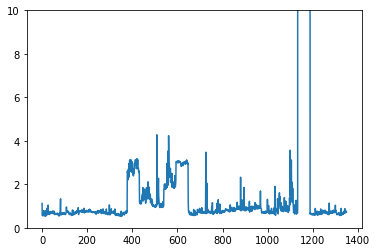

In [98]:
plt.plot(y_pred)
# plt.xlabel('X-Axis')
# plt.ylabel('Y-Axis')
# plt.xlim([0, 5])      # X축의 범위: [xmin, xmax]
plt.ylim([0, 10])     # Y축의 범위: [ymin, ymax]

plt.show()

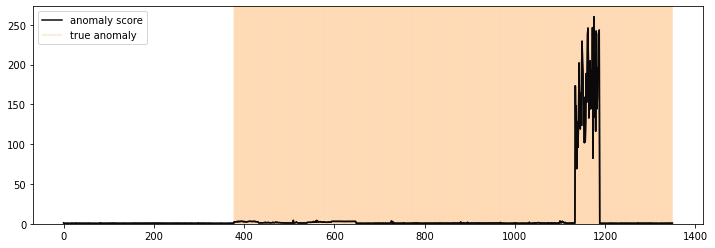

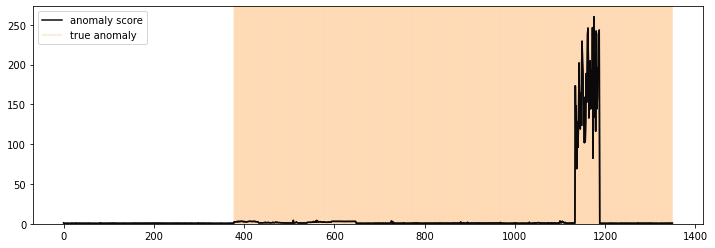

In [99]:
check_graph(y_pred, att=y_test, piece=1, threshold=None)

### Isolation Forest

In [31]:
IF_clf=IsolationForest(random_state=72).fit(Anode_Train_X)
IF_pred = IF_clf.predict(Anode_Test_X)
IF_pred = np.where(IF_pred==1, 0, 1)

In [32]:
tn, fp, fn, tp = confusion_matrix(Anode_Test_y, IF_pred).ravel()
(tn, fp, fn, tp)

(33751, 3948, 57756, 40392)

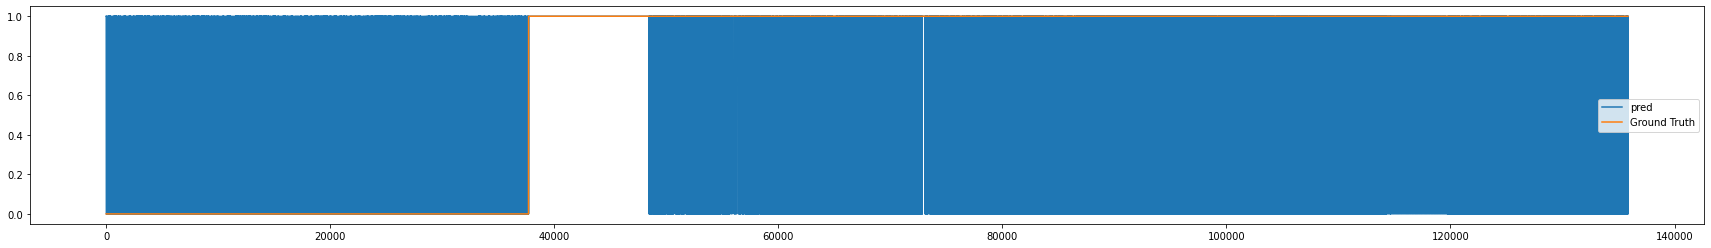

In [33]:
fig = plt.figure(figsize=(35, 4))
plt.plot(IF_pred, label='pred')
plt.plot(np.array(Anode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

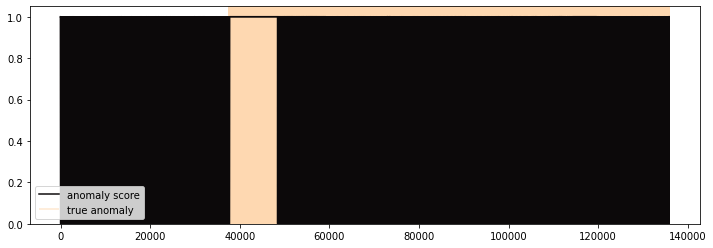

In [34]:
check_graph(IF_pred, np.array(Anode_Test_y))
plt.show()

In [35]:
IF_anomaly_score = IF_clf.score_samples(Anode_Test_X)

In [36]:
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(-IF_anomaly_score, 
                                                                  np.array(Anode_Test_y), 
                                                                  start=min(-IF_anomaly_score), 
                                                                  end=max(-IF_anomaly_score), 
                                                                  step_num=1000, 
                                                                  K=100, 
                                                                  verbose=False)
print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

AUROC: 0.7459, F1: 0.8408, Precision: 0.7429, Recall: 0.9685


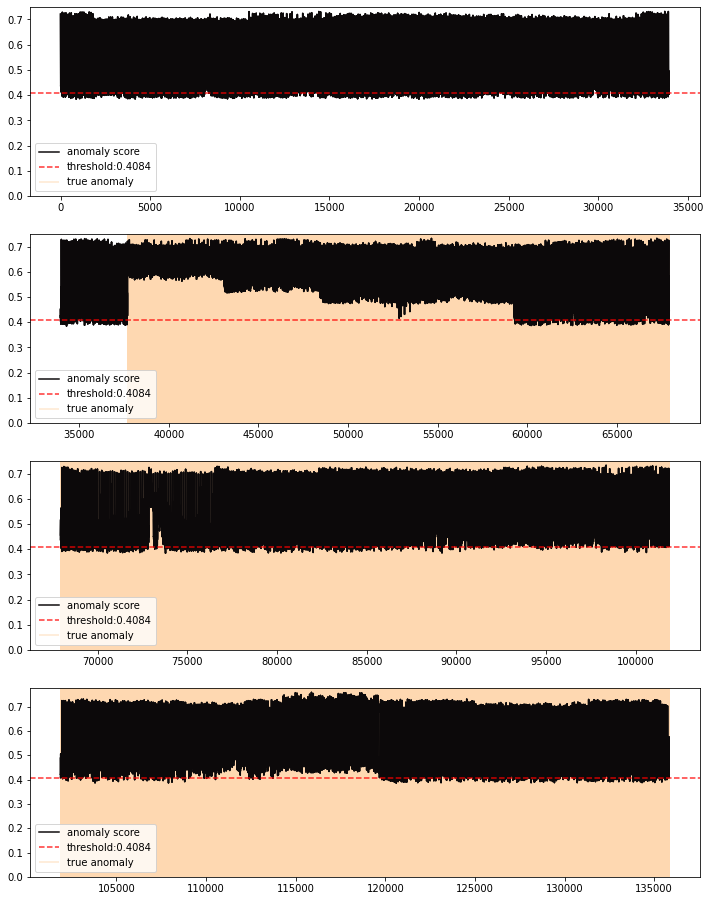

In [47]:
check_graph(-IF_anomaly_score, np.array(Anode_Test_y), threshold=threshold, piece=4)
plt.show()

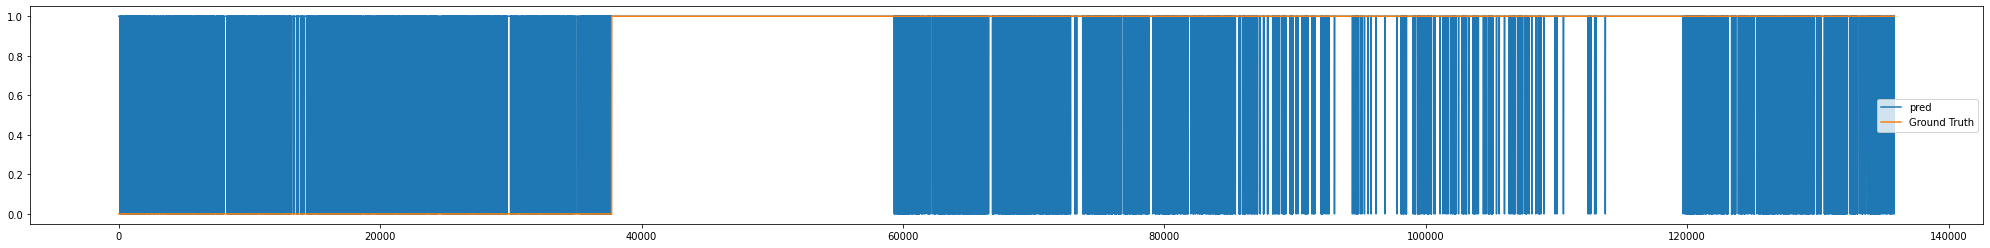

In [38]:
IF_pred = -IF_anomaly_score >= threshold
fig = plt.figure(figsize=(35, 4))
plt.plot(IF_pred, label='pred')
plt.plot(np.array(Anode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

In [77]:
Anode_Test = Anode_Test.drop('prediction', axis=1)

In [79]:
def anomaly_count_dict(testset, pred):
    anomaly_count_dict = {}
    testset['prediction'] = pred
    for bead in testset['identifier'].unique():
        anomaly_count_dict[bead] = dict(Counter(testset[testset['identifier'] == bead]['prediction']))
        
    
    return anomaly_count_dict

In [80]:
isf_anomaly_count_dict = anomaly_count_dict(Anode_Test, IF_pred)
isf_anomaly_count_dict

{'Normal_35_0': {True: 96, False: 5},
 'Normal_35_1': {True: 78, False: 22},
 'Normal_35_2': {True: 90, False: 10},
 'Normal_35_3': {True: 95, False: 5},
 'Normal_35_4': {True: 80, False: 20},
 'Normal_35_5': {True: 79, False: 21},
 'Normal_35_6': {True: 87, False: 13},
 'Normal_35_7': {True: 82, False: 18},
 'Normal_35_8': {True: 90, False: 10},
 'Normal_35_9': {True: 79, False: 21},
 'Normal_35_10': {True: 77, False: 23},
 'Normal_35_11': {True: 81, False: 19},
 'Normal_35_12': {True: 85, False: 15},
 'Normal_35_13': {True: 81, False: 19},
 'Normal_35_14': {True: 78, False: 22},
 'Normal_35_15': {True: 69, False: 31},
 'Normal_35_16': {True: 75, False: 25},
 'Normal_35_17': {True: 71, False: 29},
 'Normal_35_18': {True: 67, False: 33},
 'Normal_35_19': {True: 86, False: 13},
 'Normal_35_20': {True: 93, False: 6},
 'Normal_35_21': {True: 93, False: 6},
 'Normal_35_22': {True: 85, False: 14},
 'Normal_35_23': {True: 86, False: 13},
 'Normal_35_24': {True: 95, False: 4},
 'Normal_35_25'

In [81]:
len(isf_anomaly_count_dict)

1350

In [156]:
def anomaly_counter_each_dataset(anomaly_count_dict, ratio):
    """
    dataset별로 anomaly인 bead의 갯수가 몇개인지 출력하는 함수
    bead의 timestamp 기준 True가 전체의 ratio 이상인 경우 정상 (True), 아닌 경우 (False)로 count
    """
    anomaly_counter_each_dataset_dict = {}
    true_count = 0
    false_count = 0
    for i, bead in enumerate(anomaly_count_dict.keys()):
        try:
            if anomaly_count_dict[bead][True] > anomaly_count_dict[bead][False] * ratio /(1-ratio):
                true_count = true_count + 1
            else:
                false_count = false_count + 1
        
        except:
            if 'True' in str(anomaly_count_dict[bead]):
                true_count = true_count + 1
            
            else:
                false_count = false_count + 1
        
        if i%54 == 53:
            name_list = bead.split('_') # ['Normal', dataset, bead_num]
            name = name_list[0] + name_list[1]
            anomaly_counter_each_dataset_dict[name] = {True: true_count, False: false_count}
            
            true_count = 0
            false_count = 0
    
    return anomaly_counter_each_dataset_dict
        

In [157]:
isf_anomaly_count_dict

{'Normal_35_0': {True: 96, False: 5},
 'Normal_35_1': {True: 78, False: 22},
 'Normal_35_2': {True: 90, False: 10},
 'Normal_35_3': {True: 95, False: 5},
 'Normal_35_4': {True: 80, False: 20},
 'Normal_35_5': {True: 79, False: 21},
 'Normal_35_6': {True: 87, False: 13},
 'Normal_35_7': {True: 82, False: 18},
 'Normal_35_8': {True: 90, False: 10},
 'Normal_35_9': {True: 79, False: 21},
 'Normal_35_10': {True: 77, False: 23},
 'Normal_35_11': {True: 81, False: 19},
 'Normal_35_12': {True: 85, False: 15},
 'Normal_35_13': {True: 81, False: 19},
 'Normal_35_14': {True: 78, False: 22},
 'Normal_35_15': {True: 69, False: 31},
 'Normal_35_16': {True: 75, False: 25},
 'Normal_35_17': {True: 71, False: 29},
 'Normal_35_18': {True: 67, False: 33},
 'Normal_35_19': {True: 86, False: 13},
 'Normal_35_20': {True: 93, False: 6},
 'Normal_35_21': {True: 93, False: 6},
 'Normal_35_22': {True: 85, False: 14},
 'Normal_35_23': {True: 86, False: 13},
 'Normal_35_24': {True: 95, False: 4},
 'Normal_35_25'

In [158]:
anomaly_counter_each_dataset_dict = anomaly_counter_each_dataset(isf_anomaly_count_dict , 0.9)
anomaly_counter_each_dataset_dict

{'Normal35': {True: 16, False: 38},
 'Normal4': {True: 17, False: 37},
 'Normal5': {True: 18, False: 36},
 'Normal6': {True: 22, False: 32},
 'Normal7': {True: 24, False: 30},
 'Normal8': {True: 24, False: 30},
 'Normal9': {True: 15, False: 39},
 'Abnormal01': {True: 54, False: 0},
 'Abnormal02': {True: 54, False: 0},
 'Abnormal04': {True: 54, False: 0},
 'Abnormal05': {True: 54, False: 0},
 'Abnormal06': {True: 32, False: 22},
 'Abnormal07': {True: 33, False: 21},
 'Abnormal08': {True: 32, False: 22},
 'Abnormal09': {True: 42, False: 12},
 'Abnormal10': {True: 50, False: 4},
 'Abnormal11': {True: 54, False: 0},
 'Abnormal12': {True: 54, False: 0},
 'Abnormal13': {True: 54, False: 0},
 'Abnormal14': {True: 54, False: 0},
 'Abnormal15': {True: 54, False: 0},
 'Abnormal18': {True: 54, False: 0},
 'Abnormal24': {True: 48, False: 6},
 'Abnormal25': {True: 46, False: 8},
 'Abnormal26': {True: 45, False: 9}}

In [159]:
def metrics(anomaly_counter_each_dataset_dict):
    tn, fp, fn, tp = 0,0,0,0
    for name in anomaly_counter_each_dataset_dict.keys():
        if 'Ab' in name:
            tp = tp + anomaly_counter_each_dataset_dict[name][True]
            fn = fn + anomaly_counter_each_dataset_dict[name][False]
        
        else:
            fp = fp + anomaly_counter_each_dataset_dict[name][True]
            tn = tn + anomaly_counter_each_dataset_dict[name][False]

    recall = tp/(tp + fp)
    precision = tp/(tp + fn)
    f1 = 2*recall*precision/(recall + precision)
    
    return recall, precision, f1

In [163]:
recall, precision, f1 = metrics(anomaly_counter_each_dataset_dict)
print(f"f1: {f1:.4f}, precision: {precision:.4f}, recall: {recall:.4f}")

f1: 0.8785, precision: 0.8930, recall: 0.8645


### One-class SVM

In [121]:
OCS_clf = OneClassSVM().fit(Anode_Train_X)
OCS_pred = OCS_clf.predict(Anode_Test_X)
OCS_pred = np.where(OCS_pred==1, 0, 1)

In [122]:
tn, fp, fn, tp = confusion_matrix(Anode_Test_y, OCS_pred).ravel()
(tn, fp, fn, tp)

(18933, 18766, 33443, 64705)

In [128]:
OCS_anomaly_score = OCS_clf.score_samples(Anode_Test_X)

In [131]:
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(-OCS_anomaly_score, 
                                                                  np.array(Anode_Test_y), 
                                                                  start=min(-OCS_anomaly_score), 
                                                                  end=max(-OCS_anomaly_score), 
                                                                  step_num=1000, 
                                                                  K=100, 
                                                                  verbose=False)
print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

AUROC: 0.6102, F1: 0.8375, Precision: 0.7220, Recall: 0.9969


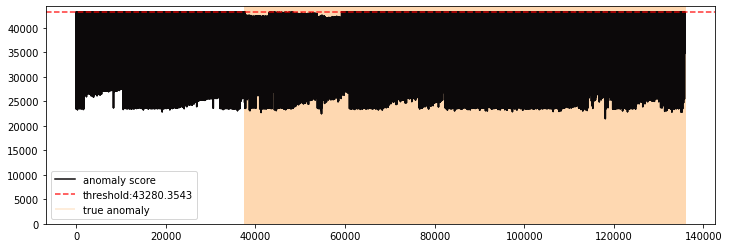

In [132]:
check_graph(OCS_anomaly_score, np.array(Anode_Test_y), threshold=-threshold)
plt.show()

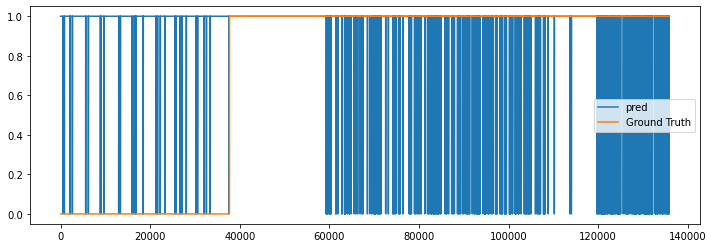

In [133]:
OCS_pred = OCS_anomaly_score <= -threshold
fig = plt.figure(figsize=(12, 4))
plt.plot(OCS_pred, label='pred')
plt.plot(np.array(Anode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

In [134]:
OCM_anomaly_count_dict = anomaly_count_dict(Anode_Test, OCS_pred)
OCM_anomaly_count_dict

{'Normal_35_0': {True: 101},
 'Normal_35_1': {True: 100},
 'Normal_35_2': {True: 100},
 'Normal_35_3': {True: 100},
 'Normal_35_4': {True: 100},
 'Normal_35_5': {True: 99, False: 1},
 'Normal_35_6': {True: 100},
 'Normal_35_7': {True: 100},
 'Normal_35_8': {True: 99, False: 1},
 'Normal_35_9': {True: 100},
 'Normal_35_10': {True: 100},
 'Normal_35_11': {True: 100},
 'Normal_35_12': {True: 100},
 'Normal_35_13': {True: 100},
 'Normal_35_14': {True: 100},
 'Normal_35_15': {True: 100},
 'Normal_35_16': {True: 100},
 'Normal_35_17': {True: 100},
 'Normal_35_18': {True: 100},
 'Normal_35_19': {True: 99},
 'Normal_35_20': {True: 98, False: 1},
 'Normal_35_21': {True: 98, False: 1},
 'Normal_35_22': {True: 99},
 'Normal_35_23': {True: 99},
 'Normal_35_24': {True: 99},
 'Normal_35_25': {True: 99},
 'Normal_35_26': {True: 98, False: 1},
 'Normal_35_27': {True: 99},
 'Normal_35_28': {True: 100},
 'Normal_35_29': {True: 99},
 'Normal_35_30': {True: 99},
 'Normal_35_31': {True: 99},
 'Normal_35_32

In [164]:
OCM_anomaly_counter_each_dataset_dict = anomaly_counter_each_dataset(OCM_anomaly_count_dict, 0.9)
OCM_anomaly_counter_each_dataset_dict

{'Normal35': {True: 54, False: 0},
 'Normal4': {True: 54, False: 0},
 'Normal5': {True: 54, False: 0},
 'Normal6': {True: 54, False: 0},
 'Normal7': {True: 54, False: 0},
 'Normal8': {True: 54, False: 0},
 'Normal9': {True: 54, False: 0},
 'Abnormal01': {True: 54, False: 0},
 'Abnormal02': {True: 54, False: 0},
 'Abnormal04': {True: 54, False: 0},
 'Abnormal05': {True: 54, False: 0},
 'Abnormal06': {True: 54, False: 0},
 'Abnormal07': {True: 54, False: 0},
 'Abnormal08': {True: 54, False: 0},
 'Abnormal09': {True: 54, False: 0},
 'Abnormal10': {True: 54, False: 0},
 'Abnormal11': {True: 54, False: 0},
 'Abnormal12': {True: 54, False: 0},
 'Abnormal13': {True: 54, False: 0},
 'Abnormal14': {True: 54, False: 0},
 'Abnormal15': {True: 54, False: 0},
 'Abnormal18': {True: 54, False: 0},
 'Abnormal24': {True: 54, False: 0},
 'Abnormal25': {True: 54, False: 0},
 'Abnormal26': {True: 54, False: 0}}

In [165]:
recall, precision, f1 = metrics(OCM_anomaly_counter_each_dataset_dict)
print(f"f1: {f1:.4f}, precision: {precision:.4f}, recall: {recall:.4f}")

f1: 0.8372, precision: 1.0000, recall: 0.7200


### MoG

In [136]:
# Define the number of mixture components (Gaussian distributions)
n_components = 2

# Create a Gaussian Mixture Model
gmm = GaussianMixture(n_components=n_components, random_state=72).fit(Anode_Train_X)

In [137]:
# Predict cluster labels for each data point
cluster_labels = gmm.predict(Anode_Test_X)

# Predict probabilities of each data point belonging to each cluster
cluster_probs = gmm.predict_proba(Anode_Test_X)

AUROC: 0.7760, F1: 0.8430, Precision: 0.7672, Recall: 0.9356


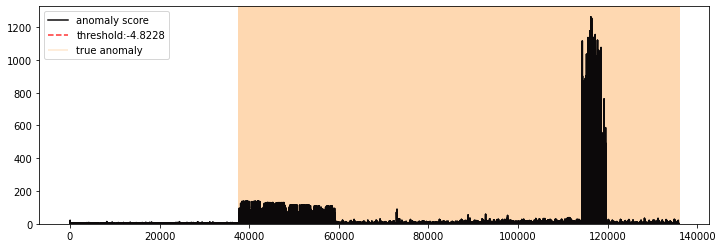

In [138]:
MoG_anomaly_score = gmm.score_samples(Anode_Test_X)

(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(-MoG_anomaly_score, 
                                                                  np.array(Anode_Test_y), 
                                                                  start=min(-MoG_anomaly_score), 
                                                                  end=max(-MoG_anomaly_score), 
                                                                  step_num=10000, 
                                                                  K=100, 
                                                                  verbose=False)
print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
check_graph(-MoG_anomaly_score, np.array(Anode_Test_y), threshold=threshold)
plt.show()

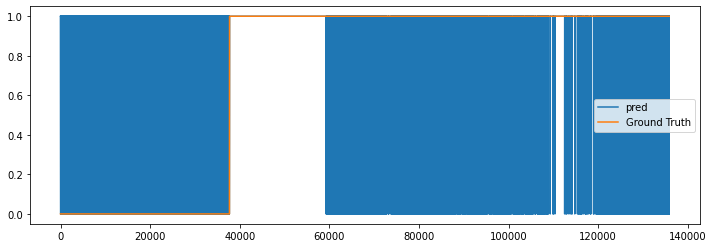

In [139]:
MoG_pred = -MoG_anomaly_score >= threshold
fig = plt.figure(figsize=(12, 4))
plt.plot(MoG_pred, label='pred')
plt.plot(np.array(Anode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

In [166]:
MOG_anomaly_count_dict = anomaly_count_dict(Anode_Test, MoG_pred)
MOG_anomaly_count_dict

{'Normal_35_0': {True: 89, False: 12},
 'Normal_35_1': {True: 70, False: 30},
 'Normal_35_2': {True: 75, False: 25},
 'Normal_35_3': {True: 72, False: 28},
 'Normal_35_4': {True: 64, False: 36},
 'Normal_35_5': {True: 74, False: 26},
 'Normal_35_6': {True: 64, False: 36},
 'Normal_35_7': {True: 75, False: 25},
 'Normal_35_8': {True: 81, False: 19},
 'Normal_35_9': {True: 78, False: 22},
 'Normal_35_10': {True: 59, False: 41},
 'Normal_35_11': {True: 71, False: 29},
 'Normal_35_12': {True: 75, False: 25},
 'Normal_35_13': {True: 58, False: 42},
 'Normal_35_14': {True: 65, False: 35},
 'Normal_35_15': {True: 54, False: 46},
 'Normal_35_16': {True: 69, False: 31},
 'Normal_35_17': {True: 74, False: 26},
 'Normal_35_18': {True: 61, False: 39},
 'Normal_35_19': {True: 70, False: 29},
 'Normal_35_20': {True: 63, False: 36},
 'Normal_35_21': {True: 78, False: 21},
 'Normal_35_22': {True: 54, False: 45},
 'Normal_35_23': {True: 58, False: 41},
 'Normal_35_24': {True: 62, False: 37},
 'Normal_3

In [167]:
MoG_anomaly_counter_each_dataset_dict = anomaly_counter_each_dataset(MOG_anomaly_count_dict, 0.9)
MoG_anomaly_counter_each_dataset_dict

{'Normal35': {True: 2, False: 52},
 'Normal4': {True: 2, False: 52},
 'Normal5': {True: 5, False: 49},
 'Normal6': {True: 1, False: 53},
 'Normal7': {True: 1, False: 53},
 'Normal8': {True: 5, False: 49},
 'Normal9': {True: 4, False: 50},
 'Abnormal01': {True: 54, False: 0},
 'Abnormal02': {True: 54, False: 0},
 'Abnormal04': {True: 54, False: 0},
 'Abnormal05': {True: 54, False: 0},
 'Abnormal06': {True: 10, False: 44},
 'Abnormal07': {True: 16, False: 38},
 'Abnormal08': {True: 13, False: 41},
 'Abnormal09': {True: 15, False: 39},
 'Abnormal10': {True: 21, False: 33},
 'Abnormal11': {True: 40, False: 14},
 'Abnormal12': {True: 46, False: 8},
 'Abnormal13': {True: 49, False: 5},
 'Abnormal14': {True: 52, False: 2},
 'Abnormal15': {True: 54, False: 0},
 'Abnormal18': {True: 54, False: 0},
 'Abnormal24': {True: 30, False: 24},
 'Abnormal25': {True: 25, False: 29},
 'Abnormal26': {True: 30, False: 24}}

In [168]:
recall, precision, f1 = metrics(MoG_anomaly_counter_each_dataset_dict)
print(f"f1: {f1:.4f}, precision: {precision:.4f}, recall: {recall:.4f}")

f1: 0.8070, precision: 0.6903, recall: 0.9711


In [ ]:
bead_counter = []
for i in range(len(MoG_pred)//54):
    bead_counter.append(dict(Counter(MoG_pred[i*54: (i+1)*54])))
print(bead_counter)

[{False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {True: 54}, {False: 54}, {False: 54}, {False: 54}]


### Parzen windows

In [143]:
bandwidth = 1.0
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(Anode_Train_X)

AUROC: 0.5579, F1: 0.8325, Precision: 0.7266, Recall: 0.9745


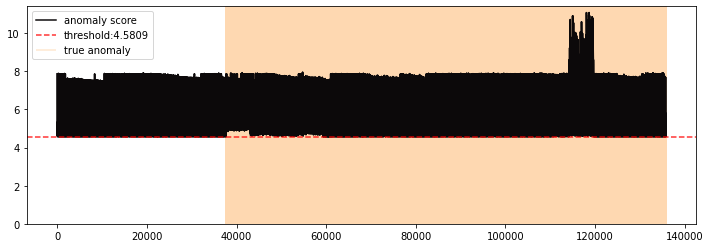

In [144]:
# Estimate the density at each value in the range
# density = np.exp(kde.score_samples(Anode_Test_X))
density = kde.score_samples(Anode_Test_X)
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(-density, 
                                                                  np.array(Anode_Test_y), 
                                                                  start=min(-density), 
                                                                  end=max(-density), 
                                                                  step_num=1000, 
                                                                  K=100, 
                                                                  verbose=False)
print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
check_graph(-density, np.array(Anode_Test_y), threshold=threshold)
plt.show()

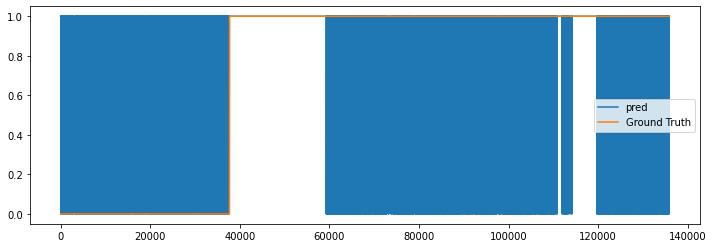

In [146]:
PW_pred = -density >= threshold
fig = plt.figure(figsize=(12, 4))
plt.plot(PW_pred, label='pred')
plt.plot(np.array(Anode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

In [170]:
PW_anomaly_count_dict = anomaly_count_dict(Anode_Test, PW_pred)
PW_anomaly_count_dict

{'Normal_35_0': {True: 100, False: 1},
 'Normal_35_1': {True: 94, False: 6},
 'Normal_35_2': {True: 95, False: 5},
 'Normal_35_3': {True: 96, False: 4},
 'Normal_35_4': {True: 94, False: 6},
 'Normal_35_5': {True: 96, False: 4},
 'Normal_35_6': {True: 95, False: 5},
 'Normal_35_7': {True: 95, False: 5},
 'Normal_35_8': {True: 94, False: 6},
 'Normal_35_9': {True: 95, False: 5},
 'Normal_35_10': {True: 94, False: 6},
 'Normal_35_11': {True: 94, False: 6},
 'Normal_35_12': {True: 95, False: 5},
 'Normal_35_13': {True: 96, False: 4},
 'Normal_35_14': {True: 96, False: 4},
 'Normal_35_15': {True: 94, False: 6},
 'Normal_35_16': {True: 95, False: 5},
 'Normal_35_17': {True: 94, False: 6},
 'Normal_35_18': {True: 95, False: 5},
 'Normal_35_19': {True: 93, False: 6},
 'Normal_35_20': {True: 93, False: 6},
 'Normal_35_21': {True: 95, False: 4},
 'Normal_35_22': {True: 92, False: 7},
 'Normal_35_23': {True: 94, False: 5},
 'Normal_35_24': {True: 99},
 'Normal_35_25': {True: 94, False: 5},
 'Nor

In [171]:
PW_anomaly_counter_each_dataset_dict = anomaly_counter_each_dataset(PW_anomaly_count_dict, 0.9)
PW_anomaly_counter_each_dataset_dict

{'Normal35': {True: 54, False: 0},
 'Normal4': {True: 54, False: 0},
 'Normal5': {True: 54, False: 0},
 'Normal6': {True: 54, False: 0},
 'Normal7': {True: 54, False: 0},
 'Normal8': {True: 54, False: 0},
 'Normal9': {True: 54, False: 0},
 'Abnormal01': {True: 54, False: 0},
 'Abnormal02': {True: 54, False: 0},
 'Abnormal04': {True: 54, False: 0},
 'Abnormal05': {True: 54, False: 0},
 'Abnormal06': {True: 54, False: 0},
 'Abnormal07': {True: 54, False: 0},
 'Abnormal08': {True: 54, False: 0},
 'Abnormal09': {True: 54, False: 0},
 'Abnormal10': {True: 54, False: 0},
 'Abnormal11': {True: 54, False: 0},
 'Abnormal12': {True: 54, False: 0},
 'Abnormal13': {True: 54, False: 0},
 'Abnormal14': {True: 54, False: 0},
 'Abnormal15': {True: 54, False: 0},
 'Abnormal18': {True: 54, False: 0},
 'Abnormal24': {True: 54, False: 0},
 'Abnormal25': {True: 53, False: 1},
 'Abnormal26': {True: 54, False: 0}}

In [172]:
recall, precision, f1 = metrics(PW_anomaly_counter_each_dataset_dict)
print(f"f1: {f1:.4f}, precision: {precision:.4f}, recall: {recall:.4f}")

f1: 0.8367, precision: 0.9990, recall: 0.7198


In [42]:
bead_counter = []
for i in range(len(PW_pred)//54):
    bead_counter.append(dict(Counter(PW_pred[i*54: (i+1)*54])))
print(bead_counter)

[{True: 1, False: 53}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 53, True: 1}, {False: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {False: 52, True: 2}, {True: 28, False: 26}, {True: 53, False: 1}, {True: 54}, {True: 54}, {True: 44, False: 10}, {False: 25, True: 29}, {True: 54}, {False: 48, True: 6}, {False: 54}, {False: 54}]


In [43]:
len(bead_counter)

25

---